In [436]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# truc pour un affichage plus convivial des matrices numpy
np.set_printoptions(precision=2, linewidth=320)
plt.close('all')

with open('TME6_lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1')
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

In [437]:
# affichage d'une lettre (= vérification bon chargement)
def tracerLettre(let):
    a = -let*np.pi/180;
    coord = np.array([[0, 0]]);
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.plot(coord[:,0],coord[:,1])
    return

def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

def discretise(x, d):
    intervalle = 360 / d
    xd = x.copy()
    for i in range(len(x)):
        xd[i] = np.floor(x[i] / intervalle)
    return xd

# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

In [438]:
def initGD(X, N):
    etats = []
    for i in range(len(X)):
        etats.append(np.floor(np.linspace(0,N-.00000001,len(X[i]))))
    return np.array(etats)

In [439]:
def learnHMM(allx, allq, N, K, initTo0=False):
    if initTo0:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    else:
        eps = 1e-8
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)
    
    # Parcours de tous les signaux et incréments de A et Pi
    for i in range(len(allq)):
        Pi[ int( allq[i][0] ) ] += 1 # incréments du premier état
        for j in range(len(allq[i]) - 1):
            A[ int( allq[i][j] ) ][ int( allq[i][j+1] ) ] += 1 # incrément du passage d'un état à un autre
            B[ int( allq[i][j] ) ][ int( allx[i][j] ) ] += 1 # incrément du passage d'un état vers une obs
        B[ int( allq[i][len(allq[i])-1] ) ][ int( allx[i][len(allq[i])-1] ) ] += 1
            
    
    # Normalisation
    A = A / np.maximum(A.sum(1).reshape(N, 1), 1) # normalisation
    B = B / np.maximum(B.sum(1).reshape(N, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A, B

In [389]:
K = 10 # discrétisation (=10 observations possibles)
N = 5  # 5 états possibles (de 0 à 4 en python) 
Xd = discretise(X,K) # ens de seq d'obs
q = initGD(Xd, N) # ens de seq d'etats  


Pi, A, B = learnHMM(Xd[Y=='a'],q[Y=='a'],N,K,True)

print(Pi)
print("------------")
print(A)
print("------------")
print(B)

[1. 0. 0. 0. 0.]
------------
[[0.79 0.21 0.   0.   0.  ]
 [0.   0.76 0.24 0.   0.  ]
 [0.   0.   0.77 0.23 0.  ]
 [0.   0.   0.   0.76 0.24]
 [0.   0.   0.   0.   1.  ]]
------------
[[0.06 0.02 0.   0.   0.   0.   0.   0.04 0.49 0.4 ]
 [0.   0.04 0.   0.13 0.09 0.13 0.02 0.09 0.41 0.09]
 [0.   0.   0.   0.02 0.12 0.5  0.31 0.04 0.   0.  ]
 [0.07 0.   0.   0.   0.   0.   0.26 0.33 0.2  0.15]
 [0.73 0.12 0.   0.   0.   0.   0.   0.02 0.02 0.12]]


In [440]:
def viterbi(x,Pi,A,B):
    delta = np.zeros((B.shape[0],len(x)))
    psy = np.zeros((B.shape[0],len(x)))
    
    # init
    delta[:,0] = np.log(Pi) + np.log(B[:,int(x[0])])
    psy[:,0] = -1
   
    # récursion
    for t in range(1,len(x)):
        for j in range(B.shape[0]):
            delta[j,t] = np.max(delta[:,t-1] + np.log(A[:,j])) + np.log(B[j,int(x[t])])
            psy[j,t] = np.argmax(delta[:,t-1] + np.log(A[:,j]))
            
    # Terminaison
    S = np.max(delta[:,-1])
    
    # Chemin
    s = np.zeros(len(x))
    s[len(x)-1] = np.argmax(delta[:,-1])
    for i in range(1,len(x)):
        s[len(x)-i-1] = psy[int(s[len(x)-i]),len(x)-i]
        
    return s, S


In [391]:
s_est, p_est = viterbi(Xd[0], Pi, A, B)

# s_est = [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.  4.]
# p_est = -38.0935655456

C:\Users\wuwen\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\wuwen\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\wuwen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [441]:
def baumwelch(Xd, itrain, itest, N, K):
    nCl = 26
    
    # init
    Pi = np.zeros((nCl, N))
    A = np.zeros((nCl, N, N))
    B = np.zeros((nCl, N, K))
    q = initGD(Xd, N)
    probaCl = np.zeros(nCl)
    nbIt = 2
    est = []
    
    # Apprentissage pour chaque modèle de lettre
    for i in range(nCl):
        Pi[i], A[i], B[i] = learnHMM(Xd[itrain[i]], q[itrain[i]], N, K)
    
    # Evaluation viterbi pour toutes les lettres de toutes les classes (part 1)
    for cl in range(nCl): # pour toutes les lettres
        proba = 0
        for i in itest[cl]: # pour toutes les obs d'une lettre
            s_est, p_est = viterbi(Xd[i], Pi[cl], A[cl], B[cl])
            q[i] = s_est # estimation état caché par viterbi
            proba += p_est
        Pi[cl], A[cl], B[cl] = learnHMM(Xd[itest[cl]], q[itest[cl]], N, K) # Réestimation du hmm
        probaCl[cl] = proba
            
    logL = np.sum(probaCl)
    est.append(logL)
    
    # Evaluation viterbi pour toutes les lettres de toutes les classes (part 2)
    for cl in range(nCl): # pour toutes les lettres
        proba = 0
        for i in itest[cl]: # pour toutes les obs d'une lettre
            s_est, p_est = viterbi(Xd[i], Pi[cl], A[cl], B[cl])
            q[i] = s_est # estimation état caché par viterbi
            proba += p_est
        Pi[cl], A[cl], B[cl] = learnHMM(Xd[itest[cl]], q[itest[cl]], N, K) # Réestimation du hmm
        probaCl[cl] = proba
            
    logLplus1 = np.sum(probaCl)
    est.append(logLplus1)
    
    while ((logL - logLplus1) / logL) >= 1e-4:
        
        nbIt += 1
        
        # Evaluation viterbi pour toutes les lettres de toutes les classes (part 3)
        for cl in range(nCl): # pour toutes les lettres
            proba = 0
            for i in itest[cl]: # pour toutes les obs d'une lettre
                s_est, p_est = viterbi(Xd[i], Pi[cl], A[cl], B[cl])
                q[i] = s_est # estimation état caché par viterbi
                proba += p_est
            Pi[cl], A[cl], B[cl] = learnHMM(Xd[itest[cl]], q[itest[cl]], N, K) # Réestimation du hmm
            probaCl[cl] = proba
            
        logL = logLplus1
        logLplus1 = np.sum(probaCl)
        est.append(logLplus1)
        
    print("est : ",est)
        
    plt.plot(est)
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Somme des probas estimées")
        
    print("Nombre it : ",nbIt)
    
    return Pi, A, B

est :  [-1453.2628323833399, -1021.8160689689722, -1017.4956753694684, -1017.4956753694684]
Nombre it :  4
0.9333333333333333


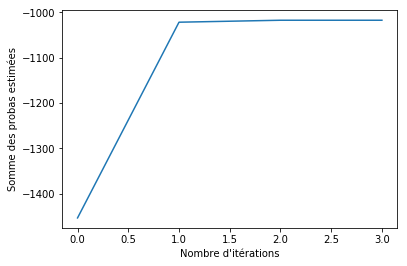

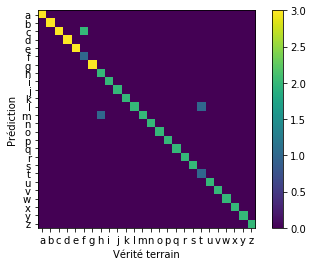

In [442]:
itrain, itest = separeTrainTest(Y, 0.8)

ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()
    
K = 10 # discrétisation (=10 observations possibles)
N = 5  # 5 états possibles (de 0 à 4 en python) 
Xd = discretise(X,K) # ens de seq d'obs
    
Pi,A,B = baumwelch(Xd, itrain,itest, N, K)  


models = [] 
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append((Pi[cl], A[cl], B[cl]))
proba = np.array([[viterbi(Xd[i], Pi[cl], A[cl], B[cl])[1] for i in it]for cl in range(26)])
Ynum = np.zeros(Y.shape)
for num,char in enumerate(np.unique(Y)):
    Ynum[Y==char] = num
pred = proba.argmax(0) # max colonne par colonne
print(np.where(pred != Ynum[it], 0.,1.).mean())
conf = np.zeros((26,26))
for k in range(len(it)):
    conf[int(pred[k])][int(Ynum[it[k]])] += 1
plt.figure()
plt.imshow(conf, interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(26),np.unique(Y))
plt.yticks(np.arange(26),np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres_30obs_5states.png")





est :  [-4556.936413777712, -3792.807634905325, -3765.7687097343432, -3762.8022227835763, -3762.8022227835763]
Nombre it :  5
Pour 5 états et 10 obervations en test :  0.75
Pour 5 états et 10 obervations en apprentissage :  0.8413461538461539
est :  [-4659.327779627817, -3863.2041156867713, -3852.3969798784765, -3852.3969798784765]
Nombre it :  4


KeyboardInterrupt: 

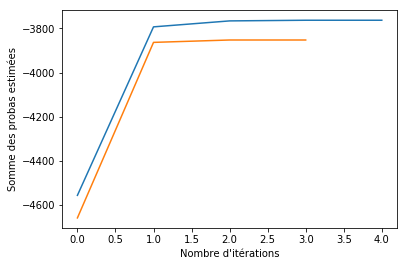

In [443]:
Ynum = np.zeros(Y.shape)
for num,char in enumerate(np.unique(Y)):
    Ynum[Y==char] = num

probas=[]
probasT=[]
Nmax=10
Kmax=20

# En test et apprentissage
for t in range(5,Nmax):
    for j in range(10,Kmax+1):
        Xd=discretise(X,j)
        q=initGD(Xd,t)
        Pi,A,B = baumwelch(Xd, itrain,itrain, t, j)  
        models = [] 
        for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
            models.append((Pi[cl], A[cl], B[cl]))
        proba = np.array([[viterbi(Xd[i], Pi[cl], A[cl], B[cl])[1] for i in range(len(Xd))]for cl in range(26)])
        pred = proba.argmax(0) # max colonne par colonne
        res=np.where(pred[it] != Ynum[it], 0.,1.).mean()
        res2=np.where(pred[ia] != Ynum[ia], 0.,1.).mean()
        print("Pour "+str(t)+" états et "+str(j)+" obervations en test : ",res)
        print("Pour "+str(t)+" états et "+str(j)+" obervations en apprentissage : ",res2)
        probasT.append(res)
        probas.append(res2)
        
       
probas = np.array(probas)
moy=probas.mean()
var=probas.std()
print("En apprentissage :\n moyenne : "+str(moy)+", variance : "+str(var))

probasT=np.array(probasT)
moyT=probasT.mean()
varT=probasT.std()
print("En test :\n moyenne : "+str(moyT)+", variance : "+str(varT))

In [444]:
def generateHMM(Pic, Ac, Bc, long):
    s = []
    x = []
    AorB = False # T = A | F = B
    
    nb_rand = np.random.rand()
    s.append(np.where(Pic >= nb_rand)[0][0])
    
    for i in range(1, long):
        nb_rand = np.random.rand()
        if AorB == False:
            x.append(np.where(Bc[int(s[len(s)-1]),:] >= nb_rand )[0][0])
            AorB = True
        else:
            s.append(np.where(Ac[int(s[len(s)-1]),:] >= nb_rand )[0][0])
            AorB = False
    
    return np.array(s), np.array(x)
        

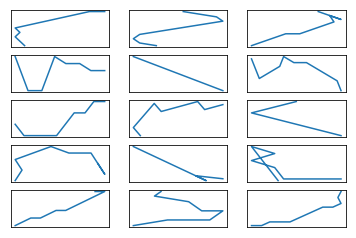

In [445]:

#Trois lettres générées pour 5 classes (A -> E)
n = 3          # nb d'échantillon par classe
nClred = 5   # nb de classes à considérer
fig = plt.figure()
for cl in range(nClred):
    Pic = models[cl][0].cumsum() # calcul des sommes cumulées pour gagner du temps
    Ac = models[cl][1].cumsum(1)
    Bc = models[cl][2].cumsum(1)
    long = np.floor(np.array([len(x) for x in Xd[itrain[cl]]]).mean()) # longueur de seq. à générer = moyenne des observations
    for im in range(n):
        s,x = generateHMM(Pic, Ac, Bc, int(long))
        intervalle = 360./10  # pour passer des états => angles
        newa_continu = np.array([i*intervalle for i in x]) # conv int => double
        sfig = plt.subplot(nClred,n,im+n*cl+1)
        sfig.axes.get_xaxis().set_visible(False)
        sfig.axes.get_yaxis().set_visible(False)
        tracerLettre(newa_continu)
plt.savefig("lettres_hmm.png")